In [6]:
import sys
sys.path.insert(0, '..')
import os
from collections import namedtuple
from typing import Any, Callable, List, Optional, Tuple, Union

import PIL
import torch 

from torchvision.datasets.utils import check_integrity, download_file_from_google_drive, extract_archive, verify_str_arg

In [15]:
cd assignment

/Users/icepainter/Desktop/assignment


In [16]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [17]:

# Model

model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
model.add_module('relu1', nn.ReLU())        
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))  
model.add_module('dropout1', nn.Dropout(p=0.5)) 

model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())        
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))   
model.add_module('dropout2', nn.Dropout(p=0.5)) 

model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module('relu3', nn.ReLU())        
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))   

model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model.add_module('relu4', nn.ReLU())  
model.add_module('pool4', nn.AvgPool2d(kernel_size=8)) 
model.add_module('flatten', nn.Flatten()) 
model.add_module('fc', nn.Linear(256, 1)) 
model.add_module('sigmoid', nn.Sigmoid()) 

# Parameter

pretrained_model = './celeba-cnn.ph'
use_cuda=True

device = torch.device("cpu")

model = model.to(device)
# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model,map_location="cpu").state_dict())
#model = model.to(device)




<All keys matched successfully>

In [18]:

# graph

image_path = './5images/000015.jpg'
image = PIL.Image.open(image_path)

transform = transforms.Compose([
    transforms.CenterCrop([178, 178]),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

image = transform(image)


In [19]:
image.shape

torch.Size([3, 64, 64])

In [20]:

# Get the feature maps from the first two conv layers
conv1_output = model[0](image.unsqueeze(0).to(device))
relu1_output = model[1](conv1_output)
pool1_output = model[2](relu1_output)
dropout1_output = model[3](pool1_output)
conv2_output = model[4](dropout1_output)
relu2_output = model[5](conv2_output)



[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


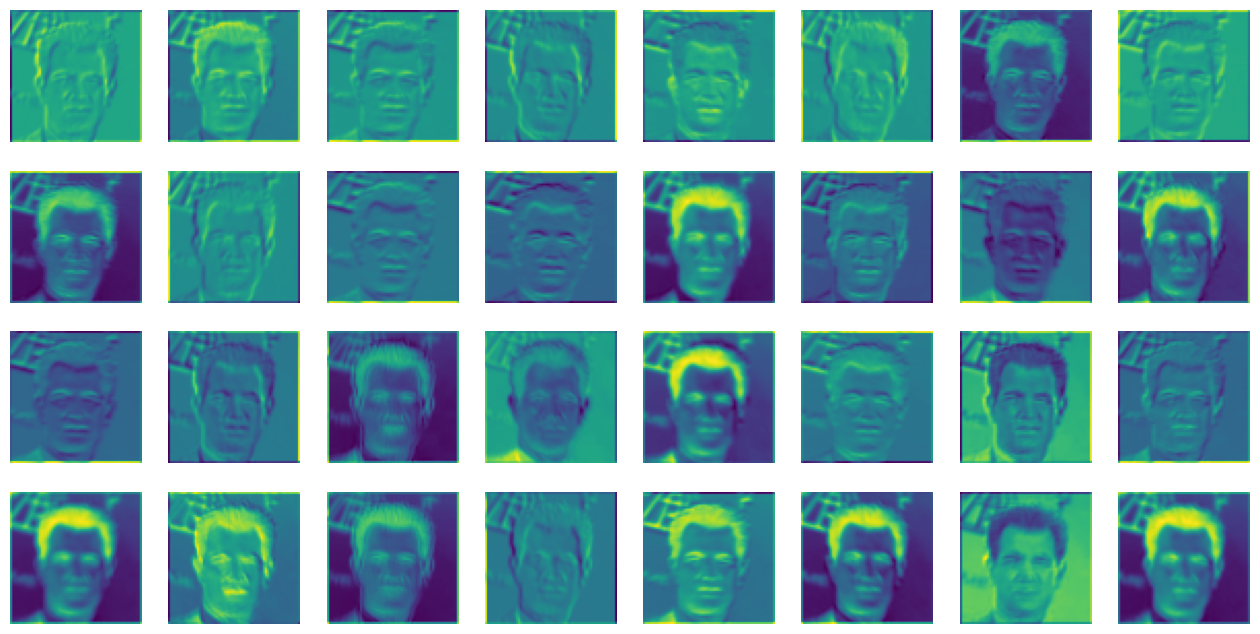

In [21]:
"print feature maps as images"


fig, axs = plt.subplots(4, 8, figsize=(16, 8))
for i in range(4):
    for j in range(8):
        axs[i][j].imshow(conv1_output[0,i*8+j,:,:].detach().numpy())
        
        axs[i][j].axis('off')
plt.show()


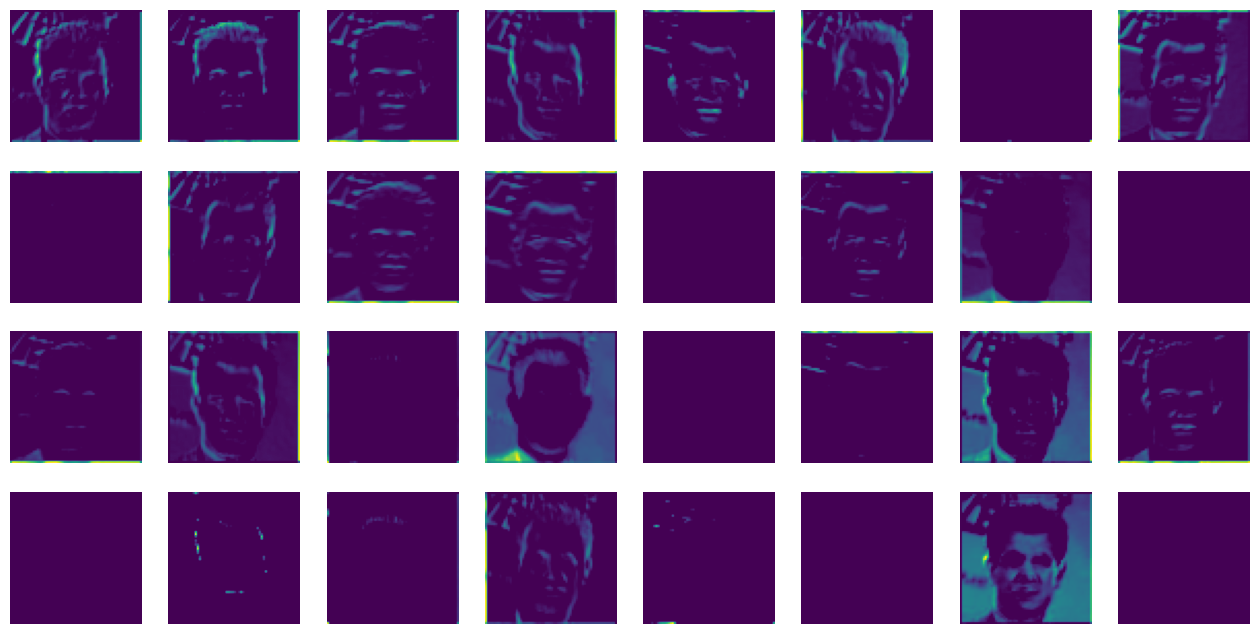

In [22]:


fig, axs = plt.subplots(4, 8, figsize=(16, 8))
for i in range(4):
    for j in range(8):
        axs[i][j].imshow(relu1_output[0,i*8+j,:,:].detach().numpy())
 
        
        axs[i][j].axis('off')
plt.show()

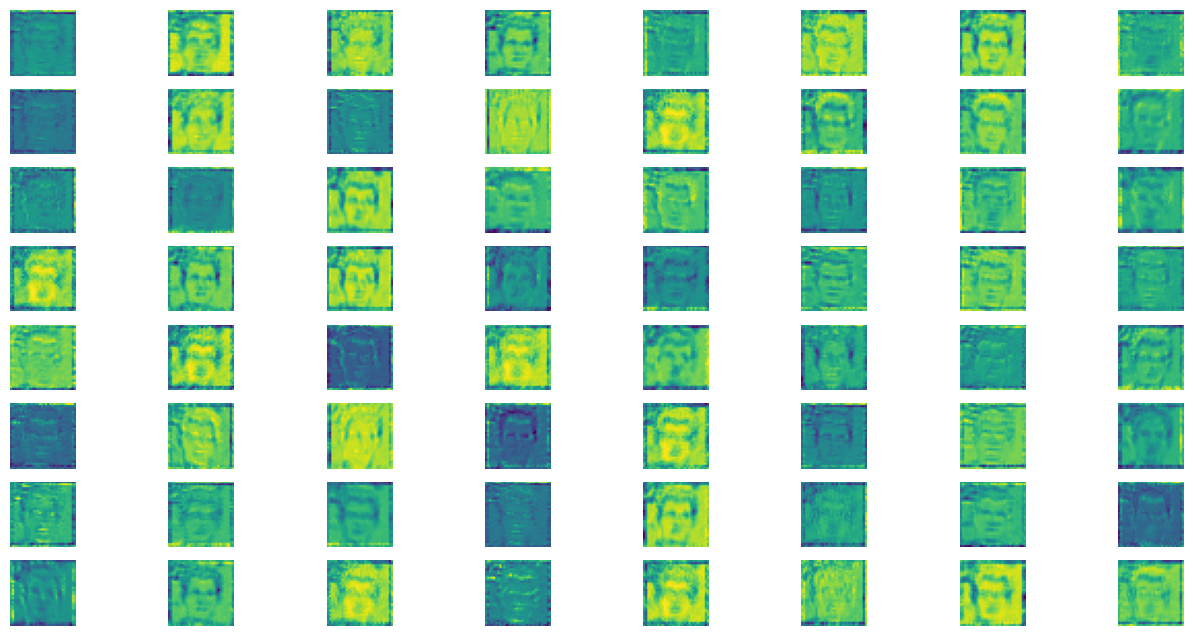

In [23]:

fig, axs = plt.subplots(8, 8, figsize=(16, 8))
for i in range(8):
    for j in range(8):
        axs[i][j].imshow(conv2_output[0,i*8+j,:,:].detach().numpy())
 
        
        axs[i][j].axis('off')
plt.show()

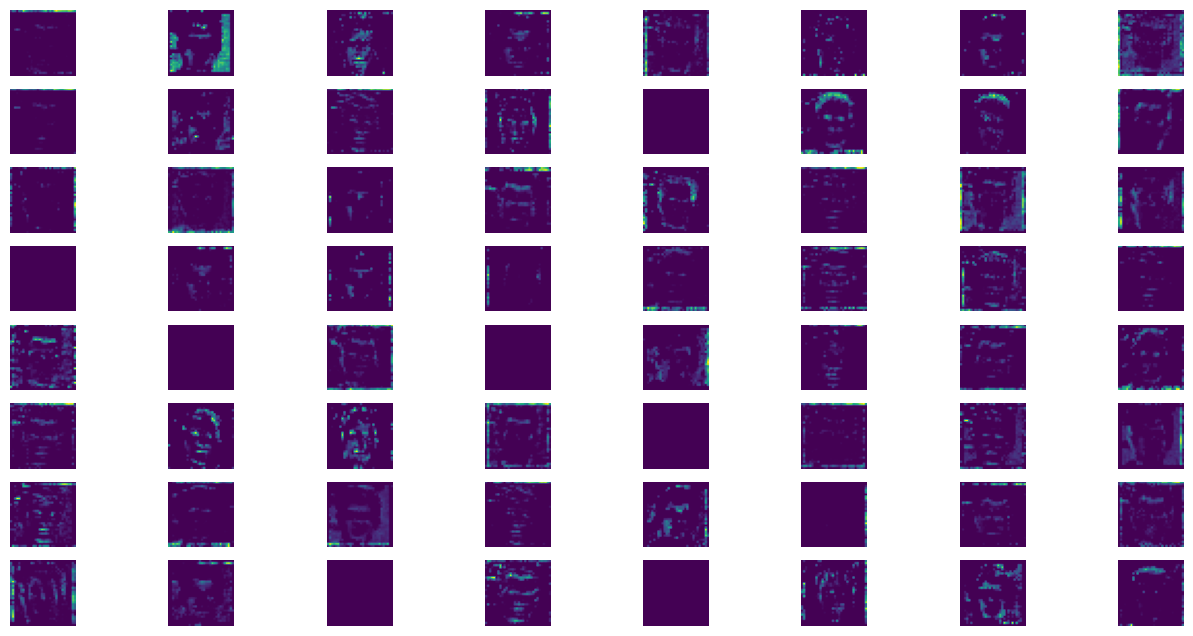

In [24]:

fig, axs = plt.subplots(8, 8, figsize=(16, 8))
for i in range(8):
    for j in range(8):
        axs[i][j].imshow(relu2_output[0,i*8+j,:,:].detach().numpy())
 
        
        axs[i][j].axis('off')
plt.show()

### Problem 2

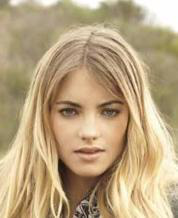

In [26]:

image1 = PIL.Image.open("./5images/000015.jpg")
image2 = PIL.Image.open("./5images/000016.jpg")
image3 = PIL.Image.open("./5images/000017.jpg")
image4 = PIL.Image.open("./5images/000018.jpg")
image5 = PIL.Image.open("./5images/000019.jpg")

In [ ]:
from torch.utils.data import TensorDataset

data = []

In [ ]:
"""back attack on  image1 - image 5"""

transform = transforms.Compose([
    transforms.CenterCrop([178, 178]),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

image1 = transform(image1).unsqueeze(0)
image2 = transform(image2).unsqueeze(0)
image3 = transform(image3).unsqueeze(0)
image4 = transform(image4).unsqueeze(0)
image5 = transform(image5).unsqueeze(0)

data.append(image1)
data.append(image2)
data.append(image3)
data.append(image4)
data.append(image5)

data = torch.stack(data, dim=0)

data = data.to(device)



In [ ]:
labels = torch.tensor([[0.00], [1.00], [1.00], [1.00], [0.00]])
labels.to(device)

dataset = TensorDataset(data, labels)

In [ ]:
def fgsm_attack(model, images, labels, eps=0.3, iters=20) :
    #images = images.to(device)
    #labels = labels.to(device)
    loss = nn.BCELoss()
    #print(images.shape)
        
    ori_images = images.data
        
    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        outputs= outputs.squeeze(1)
        #print("output {} label {}".format(outputs.data,labels.data))
        #print(outputs.dtype)
        #print(labels.dtype)
        cost = loss(outputs, labels)
        
        #cost.backward()
        grad = torch.autograd.grad(cost, images)

        adv_images = images + eps*torch.sign(grad[0])
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
        #print(images.shape)
            
    return images

In [ ]:

def test( model, device, test_loader, epsilon ):
    correct = 0
    adv_examples = []
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        #print(data.shape)
        output = model(data)
        perturbed_data = fgsm_attack(model, data, target.type(torch.float),eps=epsilon)


        # Set requires_grad attribute of tensor. Important for Attack
        #data.requires_grad = True
        # Forward pass the data through the model
        #output = model(data)
        init_pred = output.round() # get the index of the max log-probability
        print(init_pred)
        #print(target.shape)

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        #loss = F.nll_loss(output, target)
        # Zero all existing gradients
        #model.zero_grad()
        # Calculate gradients of model in backward pass
        #loss.backward()

        #data_grad = data.grad.data
        #perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)
        print(output)

        # Check for success
        final_pred = output.round() # get the index of the max log-probability
        print(final_pred)
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    return final_acc, adv_examples

In [ ]:
accu, exampls = test(model, device, dataset, 0.3)